In [1]:
## BASICS
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Circle, Wedge, Polygon
from IPython.display import display, HTML

## DSP
! pip install control
! pip install audiolazy
! pip install PyDynamic
from PyDynamic.identification.fit_filter import LSIIR
from scipy import signal, fftpack
import control
import cmath
import sympy


/usr/local/lib/python3.6/dist-packages/PyDynamic/identification/fit_filter.py:29: DeprecationWarning: The module *identification* will be combined with the module *deconvolution* and renamed to *model_estimation* in the next major release 2.0.0. From version 1.4.1 on you should only use the new module *model_estimation* instead.
  DeprecationWarning,
/usr/local/lib/python3.6/dist-packages/PyDynamic/identification/fit_transfer.py:28: DeprecationWarning: The package *identification* will be combined with the package *deconvolution* and renamed to *model_estimation* in the next major release 2.0.0. From version 1.4.1 on you should only use the new package *model_estimation* instead.
  DeprecationWarning,
/usr/local/lib/python3.6/dist-packages/PyDynamic/uncertainty/interpolation.py:28: PendingDeprecationWarning: The module :mod:`PyDynamic.uncertainty.interpolation` will be renamed to :mod:`PyDynamic.uncertainty.interpolate` in the next major release 2.0.0. From version 1.4.3 on you should 

In [2]:
sns.set_style("darkgrid")

# **PART 2 📶 - DISCRETE SIGNAL** $x[n]$
## **AGENDA**
## > Windowing (rectangular windows)
## > Discre-Time Fourier Transform (**DTFT**) as (**DFT**) (magnitude & phase)
## > Main-Lobe & Side-lobes interpretation
---


## 1. Define **discrete** signal $z[n]$ \& the rectangular windows $w_1[n], w_2[n]$

### **Signal** $z[n]$
$$z[n] = 2sin\left(\frac{3\pi n}{7}\right), \quad -\infty < n < + \infty$$

### **Rectangual widnows** $w_1[n], w_2[n]$

$$
w_1[n] = 
\begin{cases}
2, \quad -5 \leq n \leq 5\\
0, \quad elsewhere \\
\end{cases}
\qquad \qquad
w_2[n] = 
\begin{cases}
1, \quad -10 \leq n \leq 10\\
0, \quad elsewhere \\
\end{cases}
$$


### **Windowed signals** $z_1[n] = z[n]w_1[n], z_2[n] = w_2[n]$


In [3]:
def calculate_signal(n) :
  z = 2 * np.sin(3 * np.pi / 7 * n)
  return z

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning 

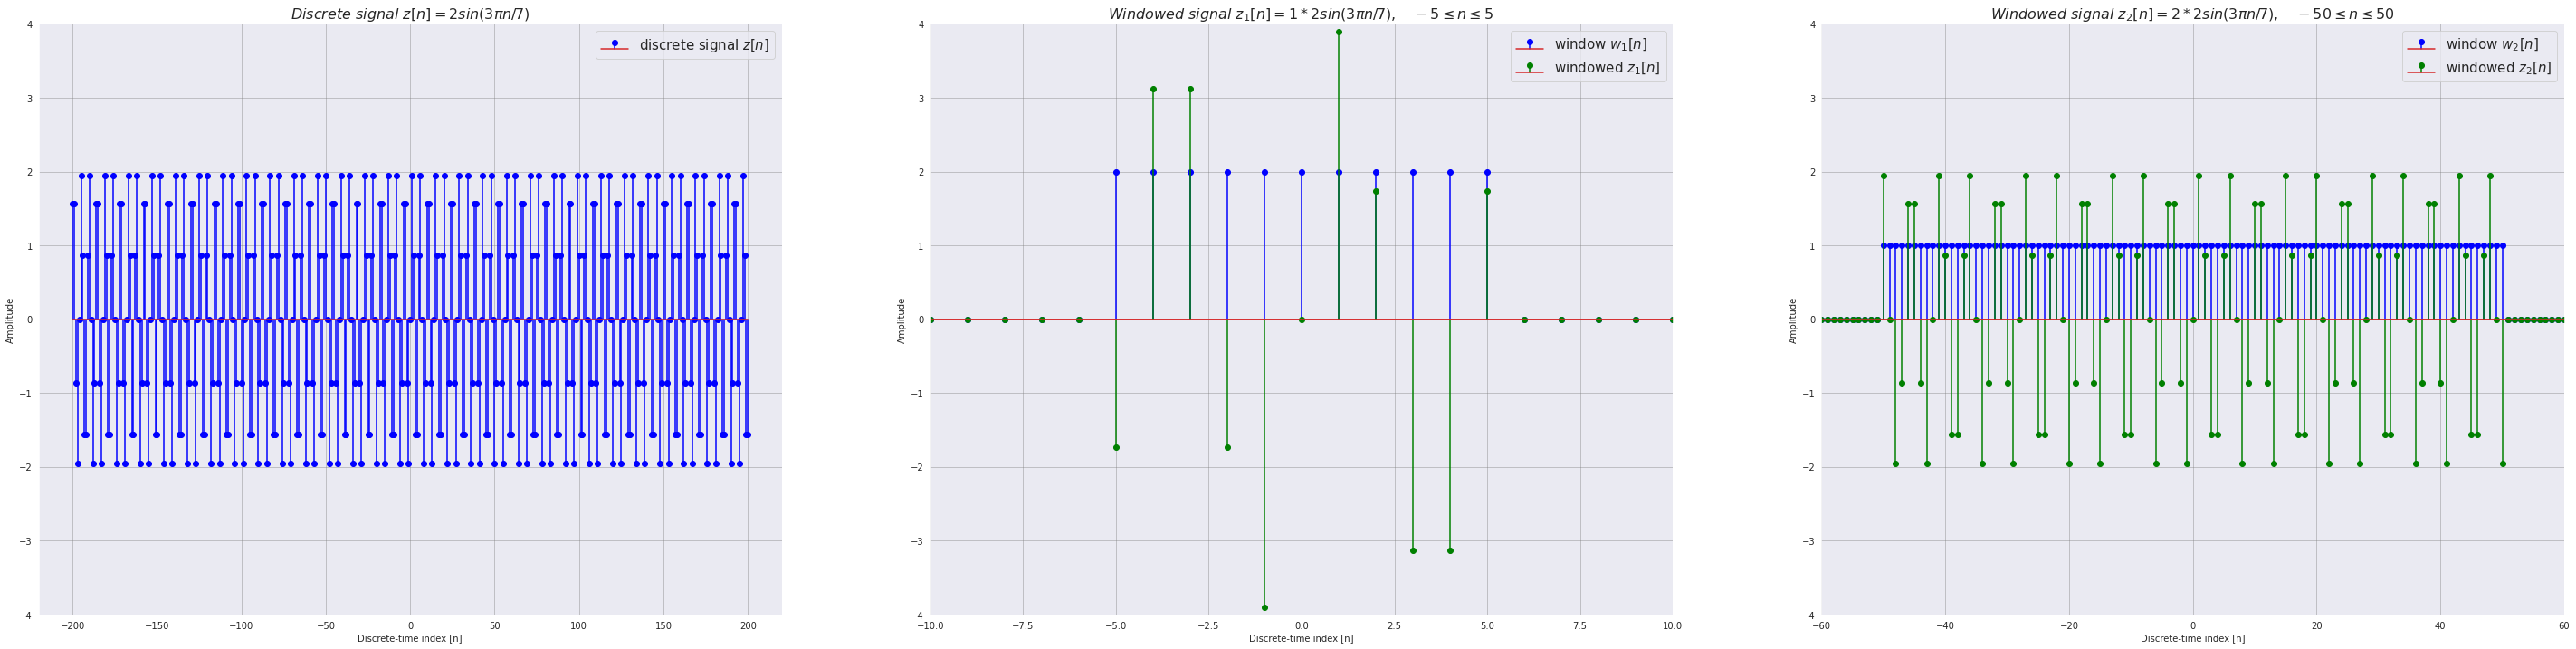

In [4]:
# 1. define the sample axis `n`, and the window signals `w1[n], w2[n]`
# [*] `N` is needed to expand the 2 rect windows. from [-100, 100], so that the 
#      the calculation of DTFT later on will give a smooth result
N = 200
N1, N2 = 5, 50
n = np.arange(-N, N + 1,1)
w1 = np.array([0] *(N - N1) + [2] * (2*N1 + 1) + [0] *(N - N1) )
w2 = np.array([0] *(N - N2) + [1] * (2*N2 + 1) + [0] *(N - N2) )

# 2. define the windowed signals `z1[n], z2[n]`
z1 = np.multiply(w1, calculate_signal(n) )
z2 = np.multiply(w2, calculate_signal(n) )

# 3. define a sampled `z[n]` for visualization purposes
z = calculate_signal(n) 

# 4. visualization
fig, axs = plt.subplots(1,3, figsize = (50,12))
axs[0].stem(n,z,linefmt = '-b',  markerfmt='bo', label = r"discrete signal $z[n]$" )
axs[0].set_title(r"Discrete signal $z[n] = 2sin(3πn/7)$ ", size = 16, style = 'italic')
axs[1].stem(n, w1, linefmt = '-b',  markerfmt='bo', label = r"window $w_1[n]$" )
axs[1].stem(n, z1, linefmt = '-g',  markerfmt='go', label = r"windowed $z_1[n]$")
axs[1].set_xlim(-10, 10)
axs[1].set_title(r"Windowed signal $z_1[n] = 1 * 2sin(3πn/7), \quad -5 \leq n \leq 5$ ", size = 16, style = 'italic')
axs[2].stem(n, w2, linefmt = '-b',  markerfmt='bo', label = r"window $w_2[n]$" )
axs[2].stem(n, z2, linefmt = '-g',  markerfmt='go', label = r"windowed $z_2[n]$")
axs[2].set_xlim(-60, 60)
axs[2].set_title(r"Windowed signal $z_2[n] = 2 * 2sin(3πn/7), \quad -50 \leq n \leq 50$ ", size = 16, style = 'italic')

for idx in range(3) : 
  axs[idx].set_xlabel('Discrete-time index [n]')
  axs[idx].set_ylabel('Amplitude')
  axs[idx].set_ylim(-4,4)
  axs[idx].grid(True, color = 'gray', alpha = 0.5)
  axs[idx].legend(fancybox = True, prop = {'size': 15})

plt.show()


## 2. Calculate the **Discrete-Time Fourier Transform (DTFT)**
### **What it is?**
* The discrete Fourier transform (DFT) converts a finite sequence of equally-spaced samples of a function into a same-length sequence of equally-spaced samples of the discrete-time Fourier transform (DTFT), which is a complex-valued function of frequency

* DTFT is a frequency analysis tool for aperiodic discrete-time
signals The DTFT of $x[n]$ has been derived as

$$ X(\omega) = \sum_{n = - \infty}^{\infty}x[n]e^{-j\omega n}, \qquad -\pi \leq \omega \leq \pi$$

* As in Fourier transform, $ X(\omega)$ **is also called spectrum and is
a continuous function of the frequency parameter $\omega$, with a period = $2\pi$**

### **Magnitude, phase** (both continuous)
$ X(\omega)$ is generally complex, we can illustrate using the
magnitude and phase spectra.

#### Magnitude $|X(\omega)|$ 

$$|X(\omega)| = \sqrt{(\mathcal{Re}\{ X(\omega)\})^{2} + (\mathcal{Im}\{ X(\omega)\})^{2} }$$

We will scale the magnitude in a decibel scale (dB). This is the commonly used unit in signal processing. We will be able to observe the **main and side lobes** better. Furthermore, we will be able to compare the magnitudes of both windowed signals



#### Phase $\angle X(\omega)$ 
$$\angle X(\omega) = tan^{-1} \left( \frac{\mathcal{Im}\{ X(\omega)\}}{\mathcal{Re}\{ X(\omega)\}}       \right)$$


### **How to calculate?**
Recall that the **FFT Algorithm** computes the discrete Fourier transform (DFT). Let's describe the relationship between (DFT) and (DTFT)

$$X[k] = X(\omega) \Big{|}_{\omega = \frac{2 \pi}{N}k}$$
We can see that DFT (discrete) of a signal occurs when we **sample** the DTFT of the signal (continuous). All this happens in the frequency domain








In [5]:
#Calculating the magnitude of DTFT
def calculate_magnitude(DTFT):
  return [ abs(x) for x in DTFT ]

#Calculating the phase 
def calculate_phase(DTFT):
  return np.angle(DTFT)
  # return [ cmath.phase(x) for x in DTFT ]

# Calculate db
def db(DTFT):
  return 20 * np.log10(np.abs(DTFT) / np.abs(DTFT).max())


z1 : Main Lobe with maximum magntide |X(ω)| = 0.0 (dB), are at ω = [ -1.4 , 1.4 ] (rad/s)
z2 : Main Lobe  with maximum magntide |X(ω)| = 0.0 (dB), are at ω = [ -1.35 , 1.35 ] (rad/s)


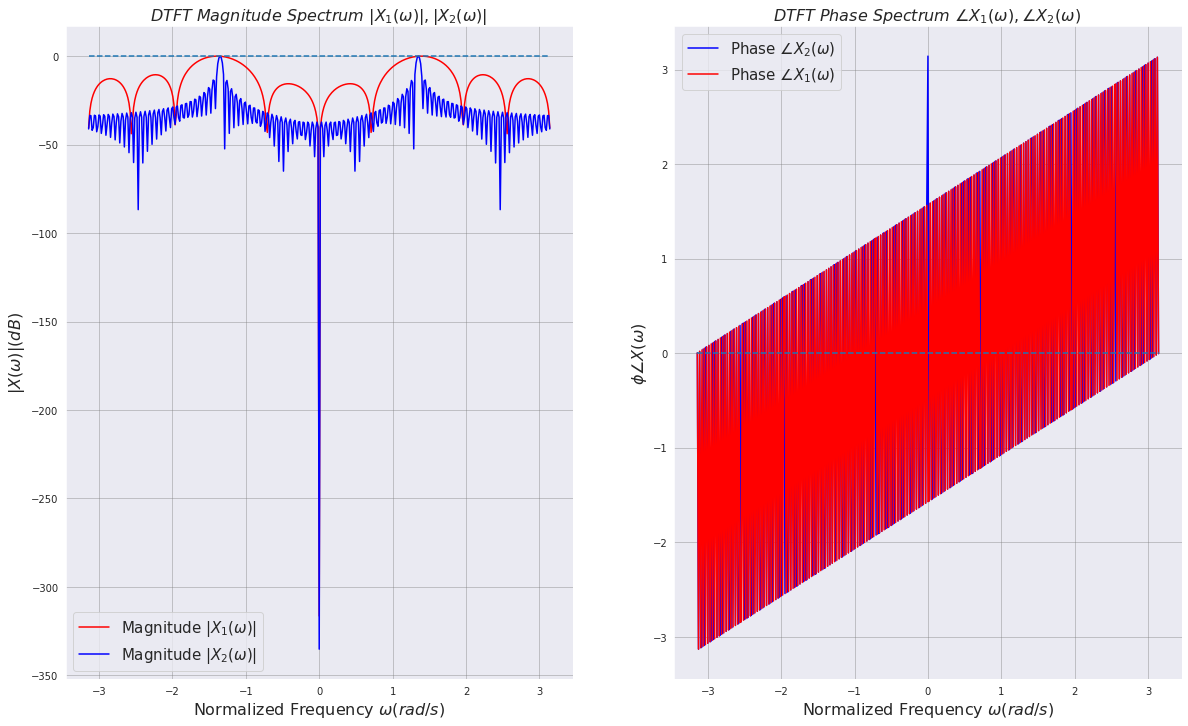

In [6]:
## 1. Define ω `axis` & Calculate DTFT, Magnitude |X(ω)|, phase < X(ω) for both z1[n], z2[n] windowed signals
DTFT1      = np.fft.fft(z1,2 *N + 1)
DTFT2      = np.fft.fft(z2,2*N + 1)
DTFT1      = np.fft.fftshift(DTFT1) # Shift the zero-frequency component to the center of the spectrum.
DTFT2      = np.fft.fftshift(DTFT2)
magnitude1 = calculate_magnitude(DTFT1)
magnitude2 = calculate_magnitude(DTFT2)
phase1     = calculate_phase(DTFT1)
phase2     = calculate_phase(DTFT2)
omega1     = np.linspace(- np.pi, np.pi, 2*N + 1)
omega2     = np.linspace(- np.pi, np.pi,2*N + 1)
zero_line1 = np.zeros(2*N + 1)

max_magnitude_idx1 = magnitude1.index(max(magnitude1))
max_magnitude_idx2 = magnitude2.index(max(magnitude2))
max_omega1 = omega1[max_magnitude_idx1]
max_omega2 = omega2[max_magnitude_idx2]
print("z1 : Main Lobe with maximum magntide |X(ω)| = {} (dB), are at ω = [ {} , {} ] (rad/s)".format(db(max_magnitude_idx1), round(max_omega1, 2), - round(max_omega1, 2)))
print("z2 : Main Lobe  with maximum magntide |X(ω)| = {} (dB), are at ω = [ {} , {} ] (rad/s)".format(db(max_magnitude_idx2),round(max_omega2, 2), - round(max_omega2, 2)))



## 2. Visualize
fig, axs = plt.subplots(1,2, figsize = (20,12))
axs[0].plot(omega1, db(magnitude1), 'r-', label = r"Magnitude $|X_1(\omega)|$")
axs[0].plot(omega2, db(magnitude2), 'b-', label = r"Magnitude $|X_2(\omega)|$")
axs[0].plot(omega1, zero_line1, '--')
# axs[0].arrow(max_omega1 - 0.25, 6, max_omega1, 0, width = 0.2) 
axs[0].set_title(r"DTFT Magnitude Spectrum $|X_1(\omega)|,|X_2(\omega)|$ ", size = 16, style = 'italic')
axs[0].set_ylabel(r'$|X(\omega)| (dB)$', fontsize = 16)

axs[1].plot(omega2, phase2, 'b-', label = r"Phase $\angle X_2(\omega)$")
axs[1].plot(omega1, phase1, 'r-', label = r"Phase $\angle X_1(\omega)$")
axs[1].plot(omega1, zero_line1, '--')
axs[1].set_title(r"DTFT Phase Spectrum $\angle X_1(\omega),\angle X_2(\omega)$ ", size = 16, style = 'italic')
axs[1].set_ylabel(r'$\phi \angle X(\omega)$', fontsize = 16)

for idx in range(2) : 
  axs[idx].set_xlabel(r'Normalized Frequency $\omega (rad/s)$', fontsize = 16)
  axs[idx].grid(True, color = 'gray', alpha = 0.5)
  axs[idx].legend(fancybox = True, prop = {'size': 15})

plt.show()


### **NOTES 📌**


#### **1. DTFT**
* For the calculation of the DTFT, we used a DFT approximation with 2 * N + 1 = 161 points. Using a longer DFT length provides more closely spaced frequency samples. This is accomplished by padding the windowed segment with 0's to match the desired DFT length and then computing the DFT, leading to "smoother" lobes

* The minimum meaningful DFT length in spectral analysis is equal to the window length. 
$$N \geq max(N1, N2) = max(5, 50) = 50$$

#### **2. Rectangular Windowing**
* The rectangular window has a rectangular shape and uniform height. The multiplication of the input signal in the time domain by the rectangular window is equivalent to convolving the spectrum of the signal with the spectrum of the rectangular window in the frequency domain, which has a sinc function characteristic.

* The rectangular window has the narrowest lobe, compared to other window functions. Thus , by using **rectangular window** we have the highest spectral leakage.

* We can improve the frequency resolution and reduce spectral smearing by using a window with a narrower mainlobe. One way to get a narrower mainlobe is to use a longer window.


#### **3. Main Lobe vs Side Lobes**
* The main lobe width will allow us to determine the spectral resolution of the signal we are analyzing. The sidel obes are "noise" that gets added to all frequency components and can hide other spectral peaks present. They are important when analyzing a signal with lots of peaks with different magnitudes. irst, the mainlobe has non-zero width, compared to an impulse with zero width. Second, the sidelobes are nonzero outside the mainlobe, compared to an impulse which is zero ''everywhere else''.

* **MAIN LOBE** : 
  * The signal $z[n] = 2sin\left(\frac{3\pi n}{7}\right)$ has fundamental normalized frequency 
$$\omega_0 = \frac{3\pi}{7} \sim 1.346 (rad/s)$$
so we expect that the DFTF will capture this information. Indeed, **both** $X_1(\omega), X_2(\omega)$ achieve the highest magnitude for $\omega \sim 1.38 (rad/s)$. Around the fundamental frequency $\omega_0$, a lobe is formed, this is the **main lobe** that captures the most spectral information.
  * So, let's compare the width of the main lobe of both DTFTs $X_1(ω), X_2(ω)$.We notice that the $width_1 \sim 15 \times width_2$. The more its frequency-domain representation resembles an impulse, the ''better'' the window. So, since the signal $z_2$ will be windowed by the rectangular window $w_2[n]$ at $2\cdot N_2 + 1 = 101$ samples,  it is rational to give better "impulse" approximation than the respective $z_1[n]$  which is windowed with the $w_1[n]$ at only $2\cdot N_1 + 1 = 11$ samples


* **SIDE LOBES** : 
  * Certainly, the frequency bin around $\omega_0$ is the strongest, but there are non-zero values around this maximum. This phenomenon is called spectral leakage because even though the windowed signals $z_1[n], z_2[n]$ are **periodic signals** of frequency $\omega_0$, if we take a part of the signals and calculate the DTFT spectrum from it, we see multiple frequencies occuring (more lobes), due to the strange behaviour at the period's boundary. These are the **side lobes**. As a result, `leakage' from a strong frequency component may mask a weak frequency component.
  * Again, if we pad the windowed signals with zeros 0's, more side lobes occur and smoohter ones. By increasing the N, we noticed that the maximum number of side lobes for both windowed signals are :


  |  |$z_1[n]$ |$z_2[n]$ |
  |:--:|:--:|:--:|
  |**#side lobes**| $3$| $\sim 49$|
